In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

from EKF import ExtendedKalmanFilter as EKF

# Symbols definition

In [2]:
#States
Tz, Tw, Tt, beta, Uwall = sp.symbols('Tz Tw Tt beta Uwall')

#Inputs
Cf, Tz_ref, Te = sp.symbols('Cf Tz_ref Te')

#Parameters
Cz, Uwin, alpha, Cwall, mw, cw, Pmax, sigma, COP, T_shift, Np = sp.symbols('Cz Uwin alpha Cwall mw cw Pmax sigma COP T_shift Np')

# Equations definition

In [3]:
# Define the state equations, output equations, state symbols, input symbols, and parameters

beta_nl = beta/(1+sp.exp(-sigma*(Tz_ref-Tz-T_shift)))

state_equations = [Tz +1/Cz*(Uwall*(Tw-Tz)+Uwin*(Te-Tz)+alpha*Np+beta_nl*(Tt-Tz)),
                    Tw+1/Cwall*(Uwall*(Te-Tw)+Uwall*(Tz-Tw)),
                    Tt+1/(mw*cw)*(Pmax*COP*Cf + beta_nl*(Tz-Tt)),
                    beta,
                    Uwall
                    ]

output_equation = [Tz,
                   Tt
                   ]

state_symbols = [Tz, Tw, Tt, beta, Uwall]
input_symbols = [Cf, Tz_ref, Te]

params_dict = { "Cz" : 6.2608e8,
                "Uwin" : 1.1362e5,
                "alpha" : 3.4024e3,
                "Cwall" : 8.1597e9,
                "mw" : 9.788e3,
                "cw" : 4186,
                "Pmax" : 8.58e6,
                "sigma" : 2.2,
                "COP" : 5.4,
                "T_shift" : 0,
                "Np" : 0
                }  

P_0 = np.diag([0.1, 0.1, 0.1, 1e5, 1e5])  # Initial state covariance estimate

# Create an instance of the ExtendedKalmanFilter class
ekf = EKF(state_equations, output_equation, state_symbols, input_symbols, params_dict, P_0)

# Reading data

In [4]:
df = pd.read_csv('Data\Data_expl_nom.csv')

Cf = df['Cf_0']
Tz_ref_anti = df['Tz_ref_anti']
Te = df['Te']
Np = df['Np']
Tz_mean = df['Tz_mean']
Tt_mean = df['Tt_mean']
Twall_mean = df['Twall_mean']
beta_true = df['beta']
Uwall_true = df['Uwall']

# Hyper parameters and initial guesses

In [5]:
Q_k = np.diag([0.010072184527956893, 0.034967016599485465, 0.017438824920601798, 201813411.02628058, 895410481723.1228]) # Process noise covariance
R_k = np.diag([0.1, 0.1]) # Measurement noise covariance
ekf.set_QR(Q_k, R_k)

# Initial guesses
beta_init = 950000
Uwall_init = 5.5955e5

# Initial conditions
y_k = np.array([Tz_mean, Tt_mean]).T
u_k = np.array([Cf, Tz_ref_anti, Te]).T
x_k_minus_1 = np.array([Tz_mean[0], Twall_mean[0], Tt_mean[0], beta_init, Uwall_init])

# Main loop

In [6]:
time_steps = len(df)

x_k_tot = np.empty((time_steps, len(state_symbols)))

for k in range(time_steps):

    x_k = ekf.ekf(x_k_minus_1, [u_k[k]], y_k[k])

    x_k_tot[k] = x_k
    
    x_k_minus_1 = x_k

# $\beta$ identification

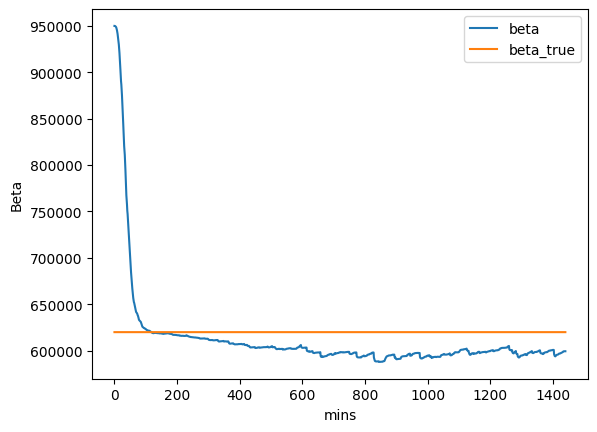

In [7]:
fig, ax = plt.subplots()
ax.plot(x_k_tot.T[3], label='beta')
ax.plot(beta_true, label='beta_true')
ax.set_xlabel('mins')
ax.set_ylabel('Beta')
ax.legend()

In [8]:
beta_err = x_k_tot.T[3][-50:].mean() - beta_true[-50:].mean()
beta_perc_err = beta_err / beta_true[-50:].mean() * 100
print(f"beta_err = {beta_err}, beta_perc_err = {beta_perc_err} %")

beta_err = -22082.971211902797, beta_perc_err = -3.562229192783391 %


# $U_{\text{wall}}$ identification


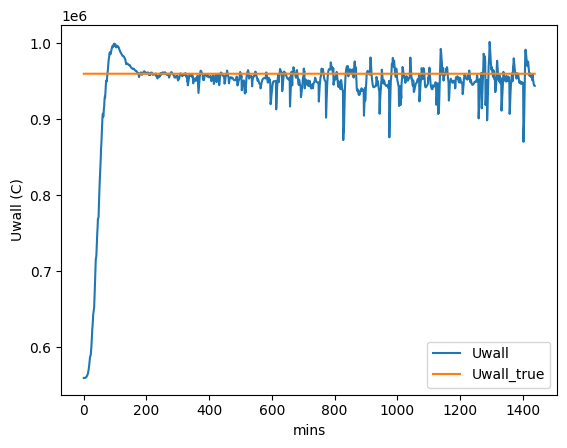

In [9]:
fig, ax = plt.subplots()
ax.plot(x_k_tot.T[4], label='Uwall')
ax.plot(Uwall_true, label='Uwall_true')
ax.set_xlabel('mins')
ax.set_ylabel('Uwall (C)')
ax.legend()

In [10]:
U_wall_err = x_k_tot.T[4][-50:].mean() - Uwall_true[-50:].mean()
U_wall_perc_err = U_wall_err / Uwall_true[-50:].mean() * 100
print(f"U_wall_err = {U_wall_err}, U_wall_perc_err = {U_wall_perc_err} %")

U_wall_err = -6714.532608576817, U_wall_perc_err = -0.6997584918531413 %
